Here we train the convolutional neural network with hyperparameter tuning.

What we first do is filter the data into training, test and validation sets. 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import PIL
import seaborn as sns
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We filter the data into train/val/test in ratio 80|10|10.

In [2]:
labeling = pd.read_csv('./labels_upsampled.csv')
labeling

,filename,item_type,label
0,100_i110.png,100,plastic
1,100_i120.png,100,plastic
2,100_i130.png,100,plastic
3,100_i140.png,100,plastic
4,100_i150.png,100,plastic
...,...,...,...
19639,327_i140_aug_x1995.png,327,"wood,paper"
19640,364_i180_aug_x1996.png,364,"wood,paper"
19641,219_i160_aug1430_aug_x1997.png,219,"wood,paper"
19642,878_i250_aug2203_aug_x1998.png,878,"wood,paper"


In [3]:
source_dir = './DataFilteredPlural/'
target_dir = './trainvaltest/'

Training via Convolutional Neural Network:
But first we need to load the data into dataloaders

In [4]:
#frequency of each class in train/val/test
train_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
val_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
test_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}

for file in os.listdir(target_dir + "train"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    train_freq[material_type] += 1
for file in os.listdir(target_dir + "val"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    val_freq[material_type] += 1
for file in os.listdir(target_dir + "test"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    test_freq[material_type] += 1


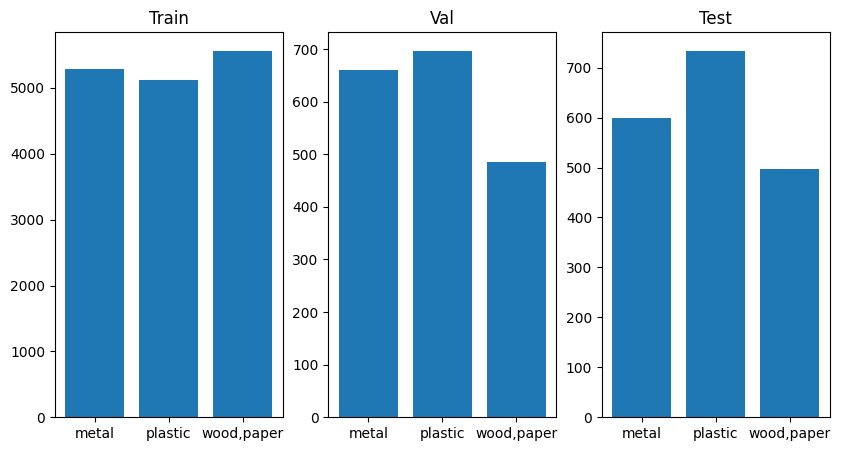

In [5]:
#plot frequency of each class in train/val/test
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(train_freq.keys(), train_freq.values())
plt.title("Train")
plt.subplot(1, 3, 2)
plt.bar(val_freq.keys(), val_freq.values())
plt.title("Val")
plt.subplot(1, 3, 3)
plt.bar(test_freq.keys(), test_freq.values())
plt.title("Test")
plt.show()

In [6]:
#calculate the factor to balance the dataset
ratio = 1/3
metal_factor = 1 / (train_freq["metal"]) * len(os.listdir(target_dir + "train")) * ratio
plastic_factor = 1 / (train_freq["plastic"]) * len(os.listdir(target_dir + "train")) * ratio
wood_paper_factor = 1 / (train_freq["wood,paper"]) * len(os.listdir(target_dir + "train")) * ratio
print("metal_factor: ", metal_factor)
print("plastic_factor: ", plastic_factor)
print("wood_paper_factor: ", wood_paper_factor)

metal_factor:  1.0067448310640443
plastic_factor:  1.0403882483225848
wood_paper_factor:  0.9564618517187686


In [7]:
#custom dataset class
class Top4Dataset(Dataset):
    def __init__(self, csv_file, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.image_names = os.listdir(root_dir)
        self.label = label
    def __len__(self):
        return len(self.image_names)
    
    def __items_class__(self):
        return self.label
    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        image = image.float()
        material_name = self.annotations[self.annotations["filename"] == img_name]["label"].values[0]
        y_label = [0.0, 0.0, 0.0]
        y_label[self.label[material_name]] = 1.0
        y_label = torch.tensor(y_label)
        path = img_name
        return (image, y_label, path)

In [8]:
material_label = {"metal": 0, "plastic": 1, "wood,paper": 2}

In [9]:
#data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144,144)),
    transforms.ToTensor(),
])

In [10]:
csv_file_label = "C:/Users/Frank/Documents/GitHub/AI_V2/convnetupsample_Plural/labels_upsampled.csv"

In [11]:
Top4Dataset_train = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "train/", label=material_label, transform=data_transforms)
Top4Dataset_val = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "val/", label=material_label, transform=data_transforms)
Top4Dataset_test = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "test/", label=material_label, transform=data_transforms)

print(f"length of train dataset: {len(Top4Dataset_train)}")
print(f"length of val dataset: {len(Top4Dataset_val)}")
print(f"length of test dataset: {len(Top4Dataset_test)}")

length of train dataset: 15971
length of val dataset: 1843
length of test dataset: 1830


In [12]:
def load_data(data_dir):
    train_dataset = Top4Dataset(csv_file=csv_file_label, root_dir=data_dir + "train/", label=material_label, transform=data_transforms)
    val_dataset = Top4Dataset(csv_file=csv_file_label, root_dir=data_dir + "val/", label=material_label, transform=data_transforms)
    test_dataset = Top4Dataset(csv_file=csv_file_label, root_dir=data_dir + "test/", label=material_label, transform=data_transforms)
    return train_dataset, val_dataset, test_dataset

In [13]:
batch_count = 8

In [14]:
DataLoader_train = DataLoader(dataset=Top4Dataset_train, batch_size=batch_count, shuffle=True)
DataLoader_val = DataLoader(dataset=Top4Dataset_val, batch_size=batch_count, shuffle=True)
DataLoader_test = DataLoader(dataset=Top4Dataset_test, batch_size=batch_count, shuffle=True)

In [15]:
label_list = ['metal', 'plastic', 'wood,paper']
DataLoader_train.dataset.__items_class__()

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

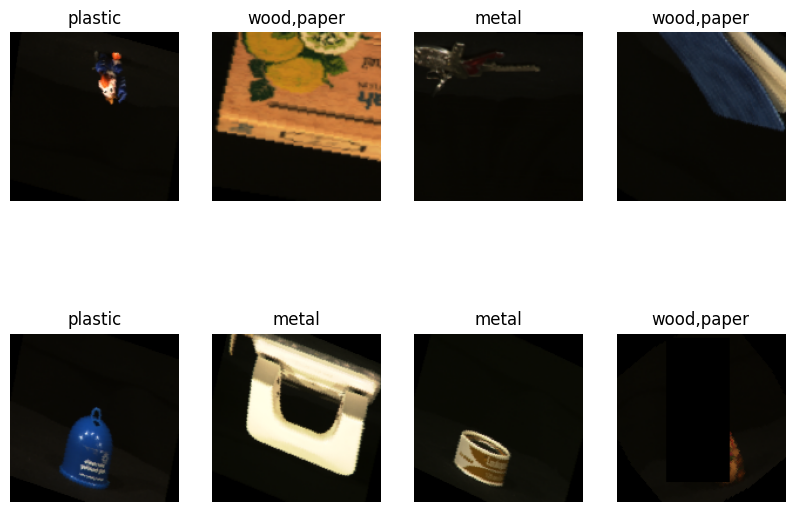

In [16]:
#show images
data = next(iter(DataLoader_train))
images, labels, path = data
plt.figure(figsize=(10, 15))
for i in range(batch_count):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(label_list[labels[i].argmax()])
    plt.axis("off")

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self, c1_out=16, c2_out=25, c1_kernel=3, c2_kernel=3, c1_stride=1, c2_stride=2, dropout=0.1):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, c1_out, kernel_size=c1_kernel, stride=c1_stride, padding= 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size= 2, stride=2),
            nn.Conv2d(c1_out, c2_out, kernel_size=c2_kernel, stride=c2_stride, padding= 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size= 2, stride=2),
        )
        self.flatten = nn.Flatten()
        s = self.flatten_counter()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(s, 3),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        logits = nn.functional.normalize(x)
        logits = self.conv_relu_stack(x)
        logits = self.flatten(logits)
        logits = self.linear_relu_stack(logits)
        return logits

    def flatten_counter(self):
        x = torch.rand(1, 3, 144, 144)
        logits = self.conv_relu_stack(x)
        logits = self.flatten(logits)
        return logits.shape[1]


Using cuda device


In [31]:
#convolutionlayer number of parameters
input_size = (3, 144, 144)
in_channels = 3
out_channels = 16
kernel_size = 3
stride = 1
padding = 1
number_of_parameters = (in_channels * out_channels * kernel_size * kernel_size) + out_channels
test = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
print(f"number of parameters: {number_of_parameters}")
print(f"number of parameters: {test.weight.numel() + test.bias.numel()}")

number of parameters: 448
number of parameters: 448


In [32]:
def test(dataloader, model, loss_fn):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, y, z) in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [33]:
def train_cifar(config, checkpoint_dir = None, data_dir = None):
    net = ConvNeuralNetwork(c1_out=config["c1_out"], c2_out=config["c2_out"], c1_kernel=config["c1_kernel"], c2_kernel=config["c2_kernel"], c1_stride=config["c1_stride"], c2_stride=config["c2_stride"], dropout=config["dropout"])
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"])


    train_dataset, val_dataset, test_dataset = load_data(data_dir)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

    for epoch in range(config["epochs"]):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, path = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 50 == 49:    # print every 50 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0
        avg_testloss = test(test_loader, net, criterion)
        if checkpoint_dir:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, "checkpoint")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, path)
        tune.report(loss=avg_testloss, accuracy=avg_testloss)    
    print('Finished Training')


In [34]:
weight = [metal_factor, plastic_factor, wood_paper_factor]
DataLoader_train.dataset.label

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

In [35]:
data_dir = "C:/Users/Frank/Documents/GitHub/AI_V2/convnetupsample_Plural/trainvaltest/"
checkpoint_dir = "./checkpoint/"

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "momentum": tune.uniform(0.1, 0.9),
    "batch_size": tune.choice([4, 8, 16, 32, 64]),
    "epochs": 50,
    "c1_out": tune.choice([16, 32, 64]),
    "c2_out": tune.choice([16, 32, 64]),
    "c1_kernel": tune.choice([3, 5, 7]),
    "c2_kernel": tune.choice([3, 5, 7]),
    "c1_stride": tune.choice([1, 2, 3]),
    "c2_stride": tune.choice([1, 2, 3]),
    "c1_pool_kernel": tune.choice([2, 3, 4]),
    "c2_pool_kernel": tune.choice([2, 3, 4]),
    "dropout": tune.uniform(0.1, 0.5),
}
train_dataset, val_dataset, test_dataset = load_data(data_dir)
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    grace_period=1,
    reduction_factor=2)
reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(train_cifar, data_dir=data_dir),
    resources_per_trial={"cpu": 1, "gpu": 1},
    config=config,
    num_samples= 10,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

best_trained_model = ConvNeuralNetwork(c1_out=best_trial.config["c1_out"], c2_out=best_trial.config["c2_out"], c1_kernel=best_trial.config["c1_kernel"], c2_kernel=best_trial.config["c2_kernel"], c1_stride=best_trial.config["c1_stride"], c2_stride=best_trial.config["c2_stride"], dropout=best_trial.config["dropout"])
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

== Status ==
Current time: 2023-01-03 21:46:54 (running for 00:00:00.22)
Memory usage on this node: 17.6/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_21-46-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+-------------+----------+------------------+-------------+-------------+----------+------------------+-------------+-----------+-------------+------------+
| Trial name              | status   | loc             |   batch_size |   c1_kernel |   c1_out |   c1_pool_kernel |   c1_stride |   c2_kernel |   c2_out |   c2_pool_kernel |   c2_stride |   dropout |          lr |   momentum |
|-------------------------+----------+------

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_cifar_c1613_00000,0.916863,2023-01-03_21-59-12,False,,c158da06705a4fac9d839ec69232774f,DESKTOP-CU406LO,10,0.916863,127.0.0.1,32532,732.86,71.4009,732.86,1672779552,0,,10,c1613_00000,0.00599837


(func pid=32532) Test Error: 
(func pid=32532)  Accuracy: 46.4%, Avg loss: 1.056576 
(func pid=32532) 
(func pid=32532) [2,    50] loss: 1.091
(func pid=32532) [2,   100] loss: 1.079
(func pid=32532) [2,   150] loss: 1.069
== Status ==
Current time: 2023-01-03 21:48:37 (running for 00:01:44.02)
Memory usage on this node: 19.6/32.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -1.0565764461542322
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects
Result logdir: C:\Users\Frank\ray_results\train_cifar_2023-01-03_21-46-53
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+-------------+----------+------------------+-------------+-------------+----------+------------------+-------------+-----------+-------------+------------+---------+------------+-----------